In [409]:
'''
in this section we will import all the libraries we need and define some global variables
'''
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas.api.types as ptypes
import plotly.express as px
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from sklearn.preprocessing import LabelEncoder
import os
from datetime import datetime
import random
import warnings
import shap
warnings.simplefilter(action="ignore", category=UserWarning)


'''
in this function we will define some global variables
'''
def reset_global_variables():
  global dataset_path, dataset, target_feature, numerical_features, categorical_features, categorial_commass, le, categories, parent_folder, logger, hyper_params, datetime_features, categorical, y_test_source, prediction_source, model_source, X_train_source, X_test_source, original_dataset
  parent_folder = None
  dataset_path = None
  dataset = None
  target_feature = None
  hyper_params = {}
  numerical_features = []
  categorical_features = []
  categorial_commass = []
  datetime_features = []
  le = LabelEncoder()
  categories = dict()
  logger = None
  categorical = None
  y_test_source, prediction_source, model_source, X_train_source, X_test_source = None, None, None, None, None
  original_dataset = None
reset_global_variables()

In [410]:
'''
in this function we will split the dataset into train and test
'''
def split_train_test(df_to_split, column_name, test_size=0.25):
  print(df_to_split.columns)
  train, test = train_test_split(df_to_split.sort_values(column_name),
                        test_size=test_size, random_state=42)

  return train, test

In [411]:
'''
in this function we will initialize the hyperparameters
'''
def initialize_hyperparameters():
    global logger, hyper_params, categorical

    if categorical:
        hyper_params = {
            "max_iter": 1000,
            "solver": "liblinear",
            "C": 1.0,
            "penalty": "l2"
        }
    else:
        hyper_params = {
            "fit_intercept": True
        }

    logger.add_action("Hyperparameter Initialization", f"Initialized {'categorical' if categorical else 'linear'} model with parameters: {hyper_params}")

In [412]:
'''
in this funcrtion we will create the prediction and return it
'''
def create_prediction(df_train, df_test, column_name):
  global hyper_params, logger, categorical
  X_train = df_train.drop(column_name,axis=1)
  X_test = df_test.drop(column_name,axis=1)

  y_train = df_train[column_name]
  y_test = df_test[column_name]

  if not hyper_params:
    initialize_hyperparameters()


  if categorical:
    model = LogisticRegression(**hyper_params)
  else:
    model = LinearRegression(**hyper_params)
  prediction = model.fit(X_train,y_train).predict(X_test)
  return y_test, prediction, model, X_train, X_test

In [413]:
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error, accuracy_score, precision_score, recall_score
'''
in this function we will print the numerical predictions metrics
'''
def print_predictions_metrics_numerical(y_test, prediction):
  output = ""
  output += "r2 score:"+"{:,.3f}\n\n".format(r2_score(y_test,prediction))
  output += "Mean Absolute Perc Error (Σ(|y - pred|/y)/n):" + "{:,.3f}\n\n".format(mean_absolute_percentage_error(y_test,prediction))
  output += "Mean Absolute Error (Σ|y - pred|/n):" + "{:,.0f}\n\n".format(mean_absolute_error(y_test, prediction))
  output += "Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):" + "{:,.0f}\n\n".format(np.sqrt(mean_squared_error(y_test, prediction)))

  ## residuals
  residuals = y_test - prediction
  max_error = residuals.abs().max()
  output += "Max Error:"+ "{:,.0f}\n".format(max_error)
  return output

'''
in this function we will print the categorical predictions metrics
'''
def print_predictions_metrics_categorical(y_test, prediction, column_name):
  category_labels = categories[column_name]
  display_labels = range(0,y_test.unique().shape[0])

  Accuracy = accuracy_score(y_test, prediction)
  Precision = precision_score(y_test, prediction, average="macro")
  return f"Accuracy: {Accuracy}\n\n Precision: {Precision}"

In [414]:
'''
in this function we will print the numerical prediction graph
'''
def print_prediction_graph_numerical(y_test, prediction):
  fig, ax = plt.subplots(figsize=(8,5))
  sns.scatterplot(x=prediction, y=y_test,ax=ax)
  sns.lineplot(x=prediction, y=prediction,ax=ax,color='black')
  plt.show()
  return fig


'''
in this function we will print the categorical prediction graph
'''
def print_prediction_graph_categorical(y_test, prediction, column_name):
  fig, ax = plt.subplots(figsize=(10,4))
  bins_size = len(categories[column_name])
  predictions_pandas = pd.Series(prediction)

  replace_dict = dict()
  category_labels = categories[column_name]
  for i, category in enumerate(category_labels):
    replace_dict[i] = category
  y_test.replace(replace_dict, inplace=True)
  predictions_pandas.replace(replace_dict, inplace=True)
  tickvalues = range(0,len(category_labels))
  plt.xticks(tickvalues, category_labels)


  # y_test.hist(ax=ax, edgecolor='black')
  # predictions_pandas.hist(ax=ax, alpha=0.5, edgecolor='black')

  predictions_pandas.value_counts().plot(kind='bar', title='Prediction')
  plt.show()
  y_test.value_counts().plot(kind='bar', title='y_test')
  plt.show()

  return fig

In [415]:
'''
in this function we will print the title of the prediction
'''
def get_cool_message(df, column_name):
    message = f"""
### 🚀 **Running Predictions on {column_name} Column** 🚀
---
"""
    return message

In [416]:
'''
in this function we will create the folder that will contain the last prediction attempt
'''
def create_parent_folder():
    timestamp = datetime.now().strftime("run-%Y-%m-%d-%H-%M")
    parent_folder = os.path.join(os.getcwd(), timestamp)
    os.makedirs(parent_folder, exist_ok=True)
    return parent_folder

'''
in this function move to the next folder
'''
def get_next_run_folder(parent_folder):
    existing_runs = [d for d in os.listdir(parent_folder) if d.startswith("run-")]
    next_run_number = len(existing_runs) + 1
    run_folder = os.path.join(parent_folder, f"run-{next_run_number}")
    os.makedirs(run_folder, exist_ok=True)
    return run_folder

'''
int this function we will save the prediction output
'''
def save_prediction_output(run_folder, column_name, text_output, fig=None):
    md_file_path = os.path.join(run_folder, f"prediction_{column_name}.md")
    img_file_path = os.path.join(run_folder, "prediction_plot.png")

    if fig:
        fig.savefig(img_file_path)

    with open(md_file_path, "w", encoding="utf-8") as f:
        f.write(f"# Prediction Results for {column_name}\n\n")
        f.write(text_output + "\n\n")

'''
in this function we will try to calculate the prediction and the errors and return the results
'''
def run_prediction(df, column_name):
    global categorial_commass, parent_folder, categorical, y_test_source, prediction_source, model_source, X_train_source, X_test_source
    df_piped = pd.DataFrame(df)
    df = df_piped.copy()
    for column in categorial_commass:
        df = df.drop(columns=[column])
    message = get_cool_message(df, column_name)
    display(Markdown(message))
    anime_train, anime_test = split_train_test(df, column_name)
    y_test, prediction, model, X_train, X_test = create_prediction(anime_train, anime_test, column_name)

    run_folder = get_next_run_folder(parent_folder)
    text_output = ""
    fig = None

    if categorical:
        text_output = print_predictions_metrics_categorical(y_test, prediction, column_name)
        fig = print_prediction_graph_categorical(y_test, prediction, column_name)
    else:
        text_output = print_predictions_metrics_numerical(y_test, prediction)
        fig = print_prediction_graph_numerical(y_test, prediction)

    print(text_output)
    save_prediction_output(run_folder, column_name, text_output, fig)
    y_test_source, prediction_source, model_source, X_train_source, X_test_source = y_test, prediction, model, X_train, X_test
    return y_test, prediction, model, X_train, X_test

In [417]:
'''
in this function we will load the dataset
'''
def load_dataset():
  global dataset
  dataset = None
  while True:
    if dataset is None:
      dataset_path = input('Enter a path to csv dataset: ')
      if dataset_path == "exit":
        return None, None
      try:
        dataset = pd.read_csv(dataset_path)
        print(f'You dataset: {dataset_path}')
      except FileNotFoundError:
        dataset = None
        print('File not found. Try again.')
        continue
    return dataset

In [418]:
'''
in this function we will choose a feature from the list of features
'''
def choose_from_list(list_features):
  for i in range(len(list_features)):
    print(f'{i + 1}. {list_features[i]}')
  feature = 0
  while int(feature) > len(list_features) or int(feature) < 1:
    feature = input('Please choose the feature: ')
    try:
      int(feature)
    except ValueError:
      print('Invalid choice. Try again.')
      continue
    if int(feature) > len(list_features) or int(feature) < 1:
      print('Invalid choice. Try again.')
  return feature

In [419]:
'''
in this function we will make log transformation on the selected feature
'''
def log_feature(dataset):
    global numerical_features, logger
    if len(numerical_features) == 0:
      print('There are no features to select')
      return dataset
    print('Please choose a numerical feature to make log transformation on it')
    feature = int(choose_from_list(numerical_features)) - 1
    dataset[numerical_features[feature]] = np.log(dataset[numerical_features[feature]])
    print(f'Log transformation applied to {numerical_features[feature]}')
    logger.add_action('Feature Transformation', f"Applied log transformation to feature '{numerical_features[feature]}'")
    _, _, _, _, _ = run_prediction(dataset, target_feature)
    return dataset

In [420]:
'''
in this function we will normalize the selected feature
'''
def normalize_feature(dataset):
    global numerical_features, logger
    if len(numerical_features) == 0:
      print('There are no features to select')
      return dataset
    print('Please choose a numerical feature to normalize it')
    feature = int(choose_from_list(numerical_features)) - 1
    mean_scored_by = dataset[numerical_features[feature]].mean()
    std_scored_by = dataset[numerical_features[feature]].std()
    dataset[numerical_features[feature]] = (dataset[numerical_features[feature]] - mean_scored_by) / std_scored_by
    logger.add_action('Feature Normalization', f"Normalized feature '{numerical_features[feature]}' with mean {mean_scored_by:.2f} and std {std_scored_by:.2f}")
    _, _, _, _, _ = run_prediction(dataset, target_feature)
    return dataset

In [421]:
'''
in this function we will reduce the outliers in the selected feature
'''
def reduce_outliers(_):
  global numerical_features, target_feature, dataset
  if len(numerical_features) == 0:
    print('There are no features to select')
    return dataset
  print('Please choose a numerical feature to reduce the outliers')
  feature = int(choose_from_list(numerical_features)) - 1
  mean = dataset[numerical_features[feature]].mean()
  std = dataset[numerical_features[feature]].std()
  print('Choose a distance in std from the mean:')
  for i in range(1, 11):
    filtered_df = dataset[(dataset[numerical_features[feature]] >= mean - i * std) & (dataset[numerical_features[feature]] <= mean + i * std)]
    print(f"{i}. after filterring by {i} std: {filtered_df.shape}")
  std_choose = 0
  while int(std_choose) > 10 or int(std_choose) < 1:
    std_choose = int(input('Your choice: '))
    if int(std_choose) > 10 or int(std_choose) < 1:
      print('Invalid choice. Try again.')
  dataset = dataset[(dataset[numerical_features[feature]] >= mean - std_choose * std) & (dataset[numerical_features[feature]] <= mean + std_choose * std)]
  logger.add_action('Outlier Reduction', f"Reduced outliers in feature '{numerical_features[feature]}' using {std_choose} standard deviations")
  _, _, _, _, _ = run_prediction(dataset, target_feature)
  return dataset


In [422]:
'''
in this function we will create boolean features from the selected feature
'''
def add_boolean_features(dataset):
  if len(categorial_commass) == 0:
    print('There are no features to select')
    return dataset
  print('Please choose a categorial feature to transformation it to boolean feature')
  feature = categorial_commass[int(choose_from_list(categorial_commass)) - 1]
  genres_split = dataset[feature].str.get_dummies(sep=', ')
  dataset = pd.concat([dataset, genres_split], axis=1)
  logger.add_action('Feature Engineering', f"Created boolean features from '{feature}'")
  y_test_source, prediction_source, model_source, X_train_source, X_test_source = run_prediction(dataset, target_feature)
  dataset = dataset.drop(columns=[feature])

  df_piped = pd.DataFrame(dataset)
  copy_df = df_piped.copy()
  corr_matrix = copy_df.corr(method='pearson')
  target_corr = corr_matrix.loc[target_feature].drop(target_feature)
  target_corr_df = pd.DataFrame(target_corr).T
  plt.figure(figsize=(12, 2))
  ax = sns.heatmap(target_corr_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
  for text in ax.texts:
    text.set_rotation(90)
  plt.title(f"Pearson Correlation of '{target_feature}'")
  plt.yticks([])
  plt.xticks(rotation=45, ha='right')
  plt.show()
  return dataset

In [423]:
'''
in this function we will binning a selected feature and will ask the number of bins the user wants
'''
def bin_numerical_feature(dataset):
    global numerical_features, logger, target_feature
    if len(numerical_features) == 0:
      print('There are no features to select')
      return dataset
    print('Please choose a numerical feature to bin')
    feature = int(choose_from_list(numerical_features)) - 1
    num_bins = int(input('Enter the number of bins: '))
    bin_labels = [f'Bin_{i+1}' for i in range(num_bins)] # labels=bin_labels

    dataset[f'{numerical_features[feature]}_binned'] = pd.qcut(
        dataset[numerical_features[feature]], q=num_bins, labels=False, duplicates='drop'
    )

    logger.add_action('Feature Binning', f"Binned feature '{numerical_features[feature]}' into {num_bins} bins")
    _, _, _, _, _ = run_prediction(dataset, target_feature)
    return dataset

In [424]:
'''
in this function we will tune the hyperparameters of the selected model
'''
def tune_hyperparameters(dataset):
    global logger, hyper_params, categrical

    if categorical:
        print("Tuning LogisticRegression hyperparameters...")
        hyper_params['max_iter'] = int(input("Enter max iterations (default: 1000): ") or 1000)
        hyper_params['solver'] = input("Enter solver (default: liblinear, options: lbfgs, saga, newton-cg, sag, liblinear): ") or "liblinear"
        hyper_params['C'] = float(input("Enter regularization strength C (default: 1.0): ") or 1.0)
        penalty = input("Enter penalty type (default: l2, options: l1, l2, elasticnet, none): ") or "l2"
        hyper_params['penalty'] = None if penalty.lower() == "none" else penalty
        model_type = "LogisticRegression"
    else:
        print("Tuning LinearRegression hyperparameters...")
        fit_intercept = input("Fit intercept? (default: True, options: True/False): ") or True
        hyper_params['fit_intercept'] = fit_intercept.lower() == "true"
        model_type = "LinearRegression"

    logger.add_action("Hyperparameter Tuning", f"Tuned {'categorical' if categorical else 'linear'} model  with parameters: {hyper_params}")
    _, _, _, _, _ = run_prediction(dataset, target_feature)
    return dataset


In [425]:
'''
in this function we will add new feature that will reprasent the number of days that past from today to a selected date feature
'''
def add_days_since_today(dataset):
    global datetime_features, logger
    if len(datetime_features) == 0:
      print('There are no features to select')
      return dataset
    print('Please choose a datetime feature to calculate days since today:')
    feature_index = int(choose_from_list(datetime_features)) - 1
    chosen_feature = datetime_features[feature_index]

    today = datetime.today()

    dataset[f'{chosen_feature}_days_since_today'] = (
        (today - pd.to_datetime(dataset[chosen_feature], origin='unix', unit='s')).dt.days
    )

    logger.add_action('Feature Engineering', f"Added '{chosen_feature}_days_since_today' based on '{chosen_feature}'")

    print(f"New feature '{chosen_feature}_days_since_today' added successfully!")
    _, _, _, _, _ = run_prediction(dataset, target_feature)
    return dataset

In [426]:
'''
in this function we will encode the categorical features
'''
def categorial_encoder(dataset):
  global categories, categorical_features
  for col in categorical_features:
    dataset[col] = le.fit_transform(dataset[col])
    valid_labels = list(le.classes_)
    categories[col] = valid_labels


In [427]:
'''
in this function we will handle the nulls in the dataset by the user's choice
'''
def handle_nulls(_):
    global numerical_features, categorical_features, categorial_commass, dataset

    print("Checking for nulls in numerical features...")
    for feature in numerical_features:
        if dataset[feature].isnull().sum() > 0:
            average = dataset[feature].mean()
            median = dataset[feature].median()
            print(f"Feature '{feature}' has {dataset[feature].isnull().sum()} null values.")
            while True:
                choice = input(f"How would you like to handle nulls for '{feature}'?\n"
                               f"1) Remove rows with nulls\n"
                               f"2) Replace with average ({average})\n"
                               f"3) Replace with median ({median})\n"
                               "4) Replace with a custom value\n"
                               "Enter your choice: ")
                if choice == '1':
                    dataset.dropna(subset=[feature], inplace=True)
                    logger.add_action('Null Handling', f"Removed rows with null values from feature '{feature}'")
                    break
                elif choice == '2':
                    dataset[feature] = dataset[feature].fillna(average)
                    logger.add_action('Null Handling', f"Replaced null values in feature '{feature}' with average ({average:.2f})")
                    break
                elif choice == '3':
                    dataset[feature] = dataset[feature].fillna(median)
                    logger.add_action('Null Handling', f"Replaced null values in feature '{feature}' with median ({median:.2f})")
                    break
                elif choice == '4':
                    custom_value = input(f"Enter the custom value for '{feature}': ")
                    logger.add_action('Null Handling', f"Replaced null values in feature '{feature}' with custom value ({custom_value})")
                    try:
                        custom_value = float(custom_value)
                        dataset[feature] = dataset[feature].fillna(custom_value)
                        break
                    except ValueError:
                        print("Invalid input. Please enter a numeric value.")
                else:
                    print("Invalid choice. Please select a valid option.")

    print("Checking for nulls in categorical features...")
    for feature in categorical_features:
        if dataset[feature].isnull().sum() > 0:
            most_common = dataset[feature].mode()[0]
            print(f"Feature '{feature}' has {dataset[feature].isnull().sum()} null values.")
            while True:
                choice = input(f"How would you like to handle nulls for '{feature}'?\n"
                               "1) Remove rows with nulls\n"
                               f"2) Replace with most common value ({most_common})\n"
                               "3) Replace with a custom value\n"
                               "Enter your choice: ")
                if choice == '1':
                    dataset.dropna(subset=[feature], inplace=True)
                    logger.add_action('Null Handling', f"Removed rows with null values from feature '{feature}'")
                    break
                elif choice == '2':
                    dataset[feature] = dataset[feature].fillna(most_common)
                    logger.add_action('Null Handling', f"Replaced null values in feature '{feature}' with the most common value: {most_common}")
                    break
                elif choice == '3':
                    custom_value = input(f"Enter the custom value for '{feature}': ")
                    dataset[feature] = dataset[feature].fillna(custom_value)
                    logger.add_action('Null Handling', f"Replaced null values in feature '{feature}' with custom value ({custom_value})")
                    break
                else:
                    print("Invalid choice. Please select a valid option.")

    print("Checking for nulls in categorial_commass features...")
    for feature in categorial_commass:
        if dataset[feature].isnull().sum() > 0:
            print(f"Feature '{feature}' has {dataset[feature].isnull().sum()} null values.")
            while True:
                choice = input(f"How would you like to handle nulls for '{feature}'?\n"
                               "1) Remove rows with nulls\n"
                               "2) Replace with 'Unknown' category\n"
                               "3) Replace with an empty list\n"
                               "Enter your choice: ")
                if choice == '1':
                    dataset.dropna(subset=[feature], inplace=True)
                    logger.add_action('Null Handling', f"Removed rows with null values from feature '{feature}'")
                    break
                elif choice == '2':
                    dataset[feature] = dataset[feature].fillna('Unknown')
                    logger.add_action('Null Handling', f"Replaced null values in feature '{feature}' with 'Unknown'")
                    break
                elif choice == '3':
                    dataset[feature] = dataset[feature].fillna('')
                    logger.add_action('Null Handling', f"Replaced null values in feature '{feature}' with an empty list")
                    break
                else:
                    print("Invalid choice. Please select a valid option.")
    print("Checking for nulls in datetime features...")
    for feature in datetime_features:
        if dataset[feature].isnull().sum() > 0:
            dataset[feature].head(20)
            print(f"Feature '{feature}' has {dataset[feature].isnull().sum()} null values.")
            while True:
                choice = input(f"How would you like to handle nulls for '{feature}'?\n"
                               "1) Remove rows with nulls\n"
                               "2) Replace with the earliest date in the column\n"
                               "3) Replace with the most common date\n"
                               "Enter your choice: ")
                if choice == '1':
                    dataset.dropna(subset=[feature], inplace=True)
                    logger.add_action('Null Handling', f"Removed rows with null values from feature '{feature}'")
                    break
                elif choice == '2':
                    earliest_date = dataset[feature].min()
                    dataset[feature] = dataset[feature].fillna(earliest_date)
                    logger.add_action('Null Handling', f"Replaced null values in feature '{feature}' with earliest date: {earliest_date}")
                    break
                elif choice == '3':
                    most_common_date = dataset[feature].mode()[0]
                    dataset[feature] = dataset[feature].fillna(most_common_date)
                    logger.add_action('Null Handling', f"Replaced null values in feature '{feature}' with most common date: {most_common_date}")
                    break
                else:
                    print("Invalid choice. Please select a valid option.")

    print("Null handling complete.")
    return dataset


In [428]:
'''
in this function we will count the unique values between commas in a selected column
'''
def counts_elements_between_commas(dataset, column):
    unique_values = set()
    for row in dataset[column].dropna():
        elements = str(row).split(",")
        cleaned_elements = []
        for e in elements:
            e = e.strip()
            e = e.replace("[","")
            e = e.replace("]","")
            e = e.replace("'","")
            cleaned_elements.append(e)

        unique_values.update(cleaned_elements)
    return len(unique_values)

'''
in this function we will pre process the dataset by selecting the numerical and categorical features and encoding the categorical features and handling the nulls
'''
def pre_process_dataset(_):
  global numerical_features, categorical_features, categorial_commass, datetime_features, categorical, dataset
  for column in dataset.columns:
    is_number = False
    random.seed(42)
    random_numbers = random.sample(range(1, len(dataset)), 7)
    for i in random_numbers:
      try:
        float(dataset[column].iloc[i])
        numerical_features.append(column)
        is_number = True
        break
      except ValueError:
        pass
    if not is_number:
      converted_date = pd.to_datetime(dataset[column], errors='coerce')
      if converted_date.notna().sum() > converted_date.isnull().sum():
        timestamps = converted_date.astype('int64') // 10**9

        # Filter out invalid timestamps
        valid_timestamps = (timestamps > 0) & (timestamps < 2**31)
        dataset[column] = timestamps.where(valid_timestamps, pd.NA)
        datetime_features.append(column)
      else:
        if dataset[column].nunique() < 100:
          categorical_features.append(column)



  for column in numerical_features:
    dataset[column] = pd.to_numeric(dataset[column], errors='coerce')
  categorial_encoder(dataset)

  comma_columns = [col for col in dataset.columns if dataset[col].astype(str).str.contains(",", regex=False).any()]
  for column in comma_columns:
    if counts_elements_between_commas(dataset, column) < 50:
      categorial_commass.append(column)

  for column in dataset.columns:
    if column not in numerical_features and column not in categorical_features and column not in categorial_commass and column not in datetime_features:
      dataset.drop(columns=[column], inplace=True)

  #if there are placeholders for null
  dataset.replace("UNKNOWN", pd.NA, inplace=True)
  dataset.replace("Unknown", pd.NA, inplace=True)
  #options to handle null values
  #1. drop rows with na
  #2. fill with average

  dataset = handle_nulls(dataset)
  #dataset.dropna(inplace=True, how='any')

  print(f"Available features are: {numerical_features + categorical_features}") #because we cant predict categorical_comma or datetime
  target_feature = 'default target feature'
  while target_feature not in dataset.columns:
    target_feature = input('Enter the target feature: ')
    if target_feature in dataset.columns:
      print(f'Target feature selected: {target_feature}')
      if target_feature in categorical_features:
        categorical = True
      else:
        categorical = False
    else:
      print('Target feature not found. Try again.')

  return dataset, target_feature

In [429]:
'''
in this function we will create a menu item class that will have a name and a method that will be called when the item is selected
'''
class MenuItem:
  def __init__(self, name, method):
    self.name = name
    self.method = method

  def action(self, dataset):
    self.method(dataset)

  def __str__(self):
    return self.name

In [430]:
'''
in this function we will create a logger item class that will have a name, a message and a step number
'''
class LogItem:
  def __init__(self, action_name, message, step_number):
    self.action_name = action_name
    self.message = message
    self.step_number = step_number

'''
in this function we will create a logger class that will log the actions that are taken by the user
'''
class Logger:
  def __init__(self):
    self.logs = []
    self.step_count = 1
  def add_action(self, action_name, message):
    new_item = LogItem(action_name, message, self.step_count)
    self.logs.append(new_item)
    self.step_count += 1
  def export_logs(self, filename='log_output'):
    global parent_folder
    with open(os.path.join(parent_folder, filename), 'w') as f:
        for log in self.logs:
            f.write(f"Step {log.step_number}: {log.message}\n")
    print(f"Logs successfully exported to {filename}")

In [431]:
'''
in this function we will create a pearson correlation graph between the target feature and the other features
'''
def pearson_correlation(df):
  global target_feature, categorial_commass
  for col in categorial_commass:
    df = df.drop(columns=[col])
  dtf_corr = df.corr(method="pearson")
  target_corr = dtf_corr.loc[target_feature].drop(target_feature)
  target_corr_df = pd.DataFrame(target_corr).T
  fig, ax = plt.subplots(figsize=(15, 2))
  sns.heatmap(target_corr_df, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, ax=ax)
  plt.show()

'''
in this function we will create a shap graph between the target feature and the other features
'''
def shap_graph(df):
  global target_feature, y_test_source, prediction_source, model_source, X_train_source, X_test_source
  explainer = shap.Explainer(model_source, X_train_source)
  shap_values = explainer(X_test_source)
  shap.plots.beeswarm(shap_values)

'''
in this function we will create a skew graph between the original dataset and the improved dataset
'''
def skew_graph(df):
  global original_dataset
  skew_original = original_dataset.skew()
  columns_to_remove = set(list(set(df.columns) - set(original_dataset.columns)) + categorial_commass)
  skew_improved = df.copy().drop(columns=columns_to_remove).skew()
  skew_comparison = pd.DataFrame({
      'Original': skew_original,
      'Improved': skew_improved
  })
  features = skew_comparison.index
  x = np.arange(len(features))
  width = 0.35
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.bar(x - width/2, skew_comparison['Original'], width, label='Original', color='skyblue')
  ax.bar(x + width/2, skew_comparison['Improved'], width, label='Improved', color='orange')
  ax.set_xlabel('Features', fontsize=12)
  ax.set_ylabel('Skewness', fontsize=12)
  ax.set_title('Skewness Comparison Between Two Models', fontsize=14)
  ax.set_xticks(x)
  plt.xticks(rotation=45, ha='right')
  ax.set_xticklabels(features, fontsize=10)
  ax.legend()
  ax.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()

analyze_menu = [MenuItem("Pearson correltion", pearson_correlation),
                MenuItem("SHAP", shap_graph),
                MenuItem("Skew", skew_graph)]

'''
in this function we will ask the user which way ih he want to analyze the dataset
'''
def analyze(_):
  global dataset
  dataset_copy = pd.DataFrame(dataset)
  df_copy = dataset_copy.copy()
  while True:
    print('Please choose an option')
    for i in range(len(analyze_menu)):
      print(f'{i + 1}. {analyze_menu[i]}')
    choice = input('Your choice: ')
    try:
      analyze_menu[int(choice) - 1].action(df_copy)
      break
    except Exception as e:
      print(e)
      print("invalid option please try again")
      continue
  return dataset


Enter a path to csv dataset: u.csv
You dataset: u.csv
The dataset loaded successfully!
Checking for nulls in numerical features...
Checking for nulls in categorical features...
Checking for nulls in categorial_commass features...
Checking for nulls in datetime features...
Null handling complete.
Available features are: ['Unnamed: 0', 'price', 'year', 'mileage', 'lot', 'brand', 'title_status', 'color', 'state', 'country', 'condition']
Enter the target feature: price
Target feature selected: price



### 🚀 **Running Predictions on price Column** 🚀
---


Index(['Unnamed: 0', 'price', 'brand', 'year', 'title_status', 'mileage',
       'color', 'lot', 'state', 'country', 'condition'],
      dtype='object')


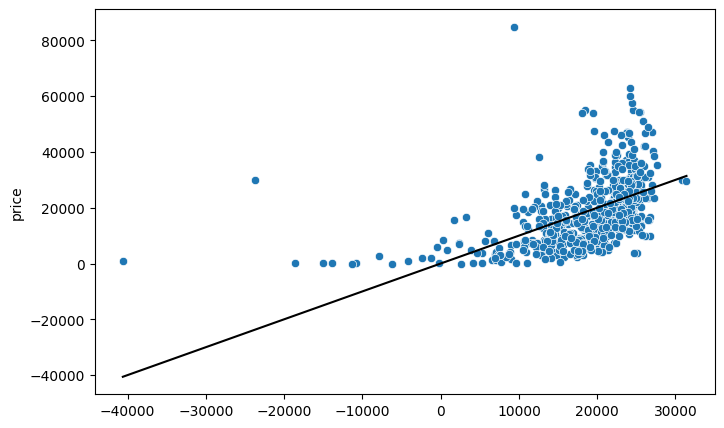

r2 score:0.220

Mean Absolute Perc Error (Σ(|y - pred|/y)/n):145,013,979,054,949,472.000

Mean Absolute Error (Σ|y - pred|/n):7,676

Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):10,374

Max Error:75,512

Please choose an option or type 'exit' for exit.
1. Outliers reduce
2. Log transformation
3. Normalize feature
4. Boolean features
5. Feature binning
6. Hyper parameters tuning
7. Days since today
8. Analyzing
Your choice: 8
Please choose an option
1. Pearson correltion
2. SHAP
3. Skew
Your choice: 1


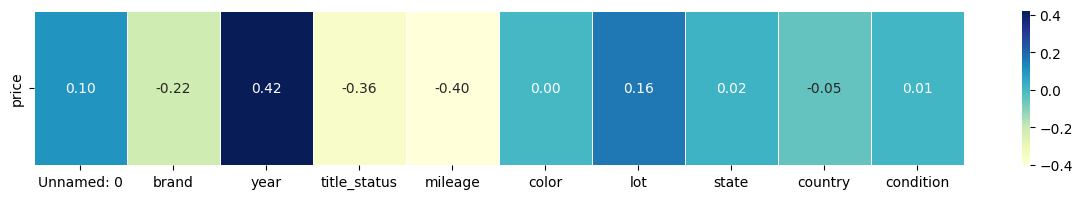

1. Outliers reduce
2. Log transformation
3. Normalize feature
4. Boolean features
5. Feature binning
6. Hyper parameters tuning
7. Days since today
8. Analyzing
Your choice: 8
Please choose an option
1. Pearson correltion
2. SHAP
3. Skew
Your choice: 2


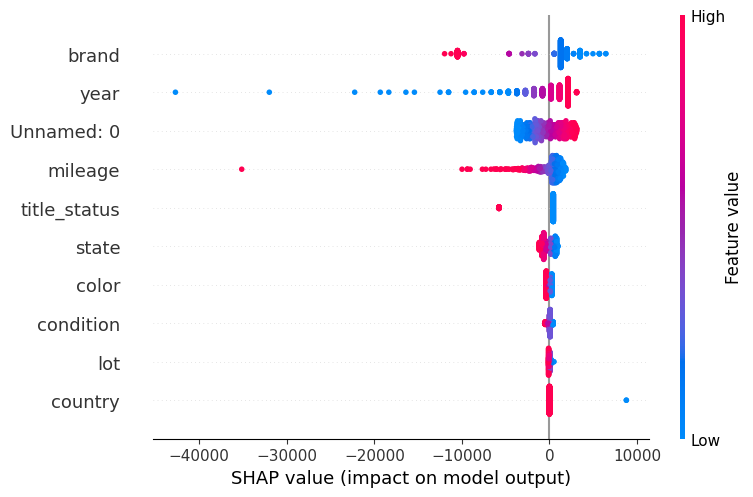

1. Outliers reduce
2. Log transformation
3. Normalize feature
4. Boolean features
5. Feature binning
6. Hyper parameters tuning
7. Days since today
8. Analyzing
Your choice: 8
Please choose an option
1. Pearson correltion
2. SHAP
3. Skew
Your choice: 3


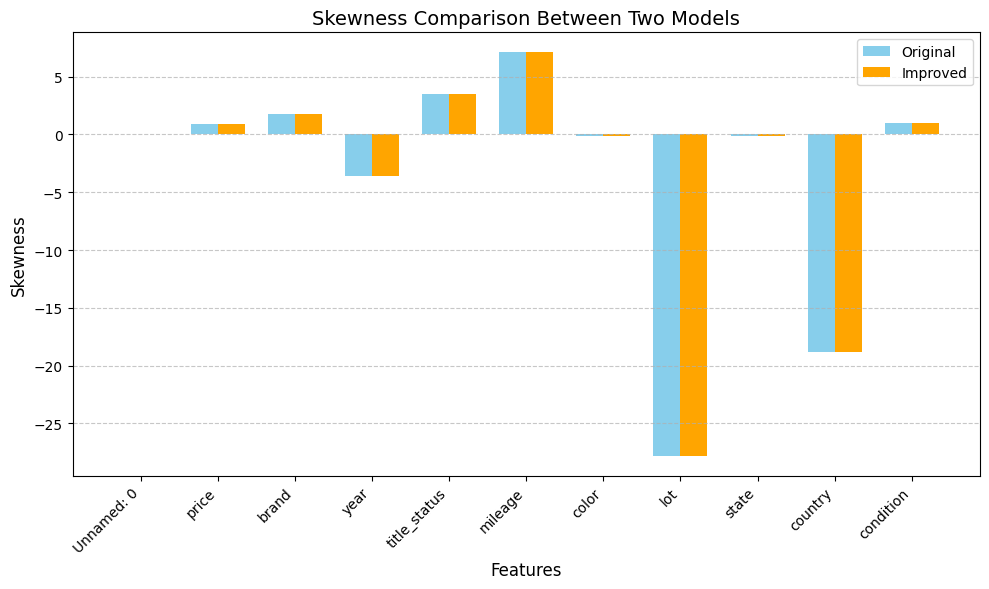

1. Outliers reduce
2. Log transformation
3. Normalize feature
4. Boolean features
5. Feature binning
6. Hyper parameters tuning
7. Days since today
8. Analyzing
Your choice: 1
Please choose a numerical feature to reduce the outliers
1. Unnamed: 0
2. price
3. year
4. mileage
5. lot
Please choose the feature: 2
Choose a distance in std from the mean:
1. after filterring by 1 std: (1752, 11)
2. after filterring by 2 std: (2381, 11)
3. after filterring by 3 std: (2474, 11)
4. after filterring by 4 std: (2496, 11)
5. after filterring by 5 std: (2498, 11)
6. after filterring by 6 std: (2499, 11)
7. after filterring by 7 std: (2499, 11)
8. after filterring by 8 std: (2499, 11)
9. after filterring by 9 std: (2499, 11)
10. after filterring by 10 std: (2499, 11)
Your choice: 2



### 🚀 **Running Predictions on price Column** 🚀
---


Index(['Unnamed: 0', 'price', 'brand', 'year', 'title_status', 'mileage',
       'color', 'lot', 'state', 'country', 'condition'],
      dtype='object')


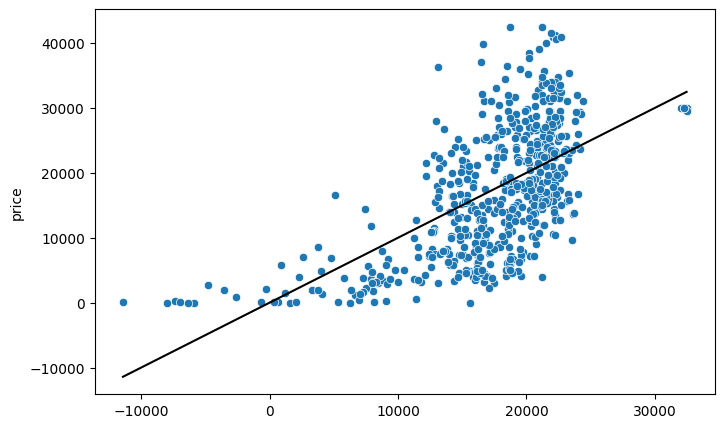

r2 score:0.370

Mean Absolute Perc Error (Σ(|y - pred|/y)/n):330,429,290,870,500,864.000

Mean Absolute Error (Σ|y - pred|/n):6,407

Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):7,734

Max Error:23,780

1. Outliers reduce
2. Log transformation
3. Normalize feature
4. Boolean features
5. Feature binning
6. Hyper parameters tuning
7. Days since today
8. Analyzing
Your choice: 6
Tuning LinearRegression hyperparameters...
Fit intercept? (default: True, options: True/False): False



### 🚀 **Running Predictions on price Column** 🚀
---


Index(['Unnamed: 0', 'price', 'brand', 'year', 'title_status', 'mileage',
       'color', 'lot', 'state', 'country', 'condition'],
      dtype='object')


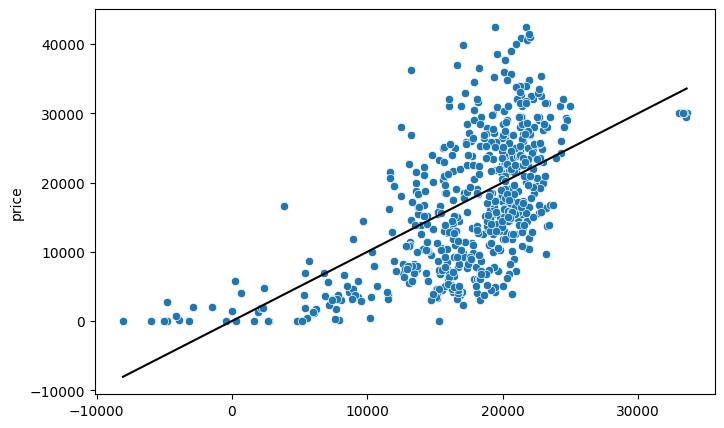

r2 score:0.370

Mean Absolute Perc Error (Σ(|y - pred|/y)/n):282,142,356,534,380,160.000

Mean Absolute Error (Σ|y - pred|/n):6,391

Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):7,736

Max Error:23,084

1. Outliers reduce
2. Log transformation
3. Normalize feature
4. Boolean features
5. Feature binning
6. Hyper parameters tuning
7. Days since today
8. Analyzing
Your choice: 5
Please choose a numerical feature to bin
1. Unnamed: 0
2. price
3. year
4. mileage
5. lot
Please choose the feature: 4
Enter the number of bins: 100



### 🚀 **Running Predictions on price Column** 🚀
---


Index(['Unnamed: 0', 'price', 'brand', 'year', 'title_status', 'mileage',
       'color', 'lot', 'state', 'country', 'condition', 'mileage_binned'],
      dtype='object')


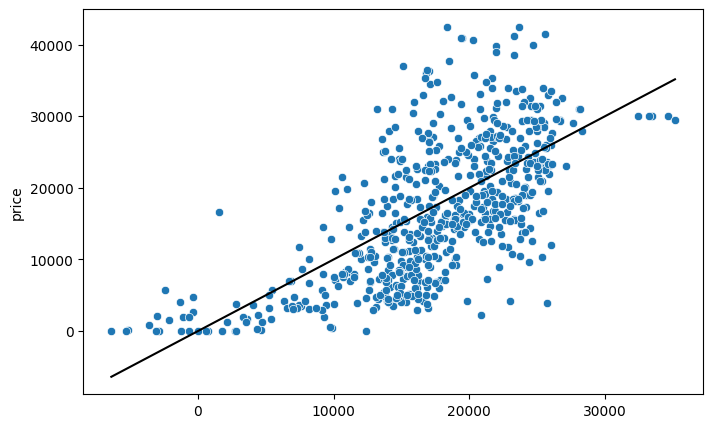

r2 score:0.429

Mean Absolute Perc Error (Σ(|y - pred|/y)/n):205,386,457,015,694,176.000

Mean Absolute Error (Σ|y - pred|/n):5,885

Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):7,361

Max Error:24,177

1. Outliers reduce
2. Log transformation
3. Normalize feature
4. Boolean features
5. Feature binning
6. Hyper parameters tuning
7. Days since today
8. Analyzing
Your choice: 5
Please choose a numerical feature to bin
1. Unnamed: 0
2. price
3. year
4. mileage
5. lot
Please choose the feature: 5
Enter the number of bins: 100



### 🚀 **Running Predictions on price Column** 🚀
---


Index(['Unnamed: 0', 'price', 'brand', 'year', 'title_status', 'mileage',
       'color', 'lot', 'state', 'country', 'condition', 'mileage_binned',
       'lot_binned'],
      dtype='object')


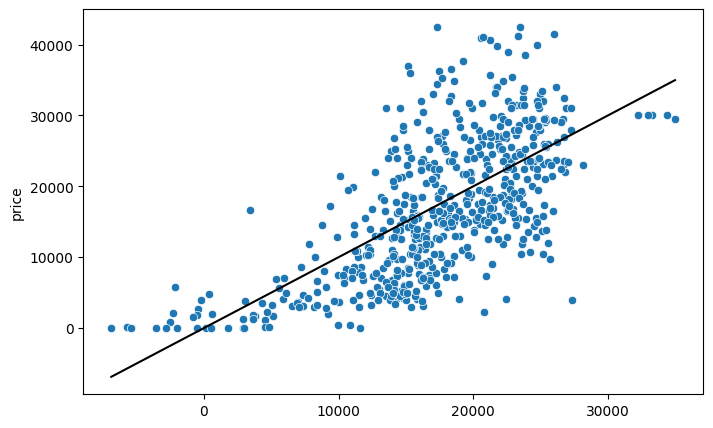

r2 score:0.441

Mean Absolute Perc Error (Σ(|y - pred|/y)/n):200,155,972,590,022,784.000

Mean Absolute Error (Σ|y - pred|/n):5,821

Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):7,285

Max Error:25,206

1. Outliers reduce
2. Log transformation
3. Normalize feature
4. Boolean features
5. Feature binning
6. Hyper parameters tuning
7. Days since today
8. Analyzing
Your choice: 1
Please choose a numerical feature to reduce the outliers
1. Unnamed: 0
2. price
3. year
4. mileage
5. lot
Please choose the feature: 2
Choose a distance in std from the mean:
1. after filterring by 1 std: (1521, 13)
2. after filterring by 2 std: (2314, 13)
3. after filterring by 3 std: (2381, 13)
4. after filterring by 4 std: (2381, 13)
5. after filterring by 5 std: (2381, 13)
6. after filterring by 6 std: (2381, 13)
7. after filterring by 7 std: (2381, 13)
8. after filterring by 8 std: (2381, 13)
9. after filterring by 9 std: (2381, 13)
10. after filterring by 10 std: (2381, 13)
Your choice: 2



### 🚀 **Running Predictions on price Column** 🚀
---


Index(['Unnamed: 0', 'price', 'brand', 'year', 'title_status', 'mileage',
       'color', 'lot', 'state', 'country', 'condition', 'mileage_binned',
       'lot_binned'],
      dtype='object')


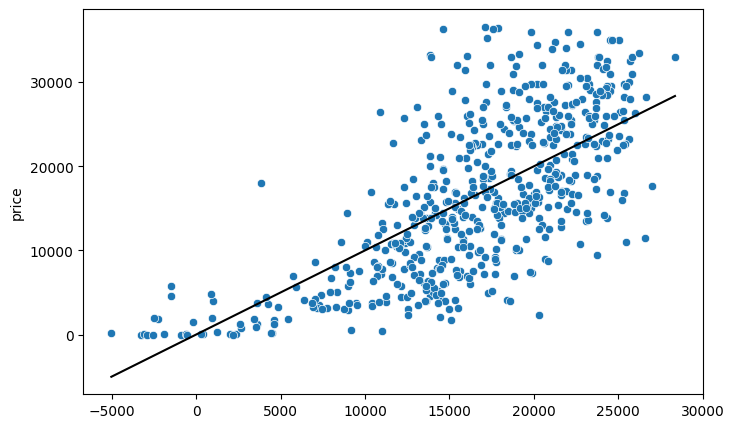

r2 score:0.495

Mean Absolute Perc Error (Σ(|y - pred|/y)/n):96,447,863,419,523,472.000

Mean Absolute Error (Σ|y - pred|/n):5,334

Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):6,679

Max Error:21,676

1. Outliers reduce
2. Log transformation
3. Normalize feature
4. Boolean features
5. Feature binning
6. Hyper parameters tuning
7. Days since today
8. Analyzing
Your choice: 8
Please choose an option
1. Pearson correltion
2. SHAP
3. Skew
Your choice: 1


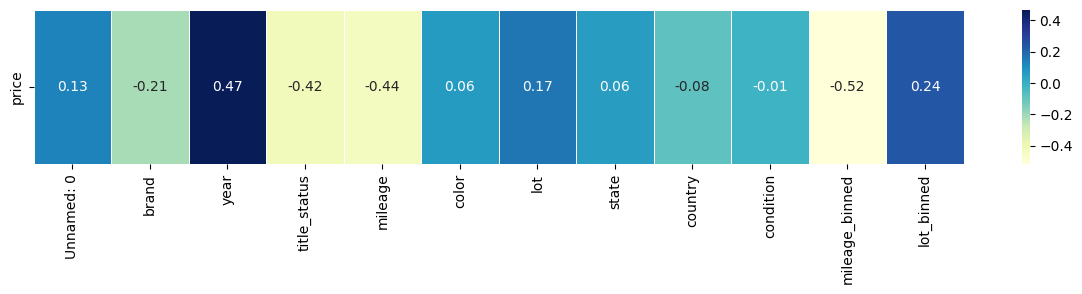

1. Outliers reduce
2. Log transformation
3. Normalize feature
4. Boolean features
5. Feature binning
6. Hyper parameters tuning
7. Days since today
8. Analyzing
Your choice: 8
Please choose an option
1. Pearson correltion
2. SHAP
3. Skew
Your choice: 2


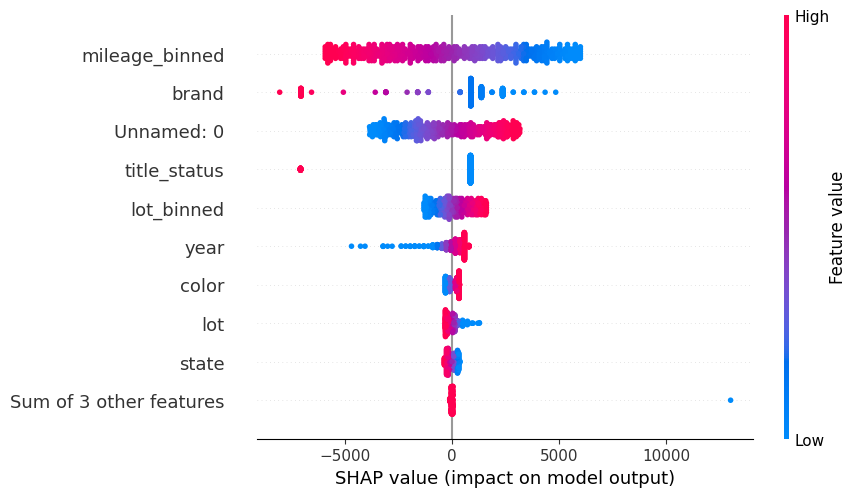

1. Outliers reduce
2. Log transformation
3. Normalize feature
4. Boolean features
5. Feature binning
6. Hyper parameters tuning
7. Days since today
8. Analyzing
Your choice: 8
Please choose an option
1. Pearson correltion
2. SHAP
3. Skew
Your choice: 3


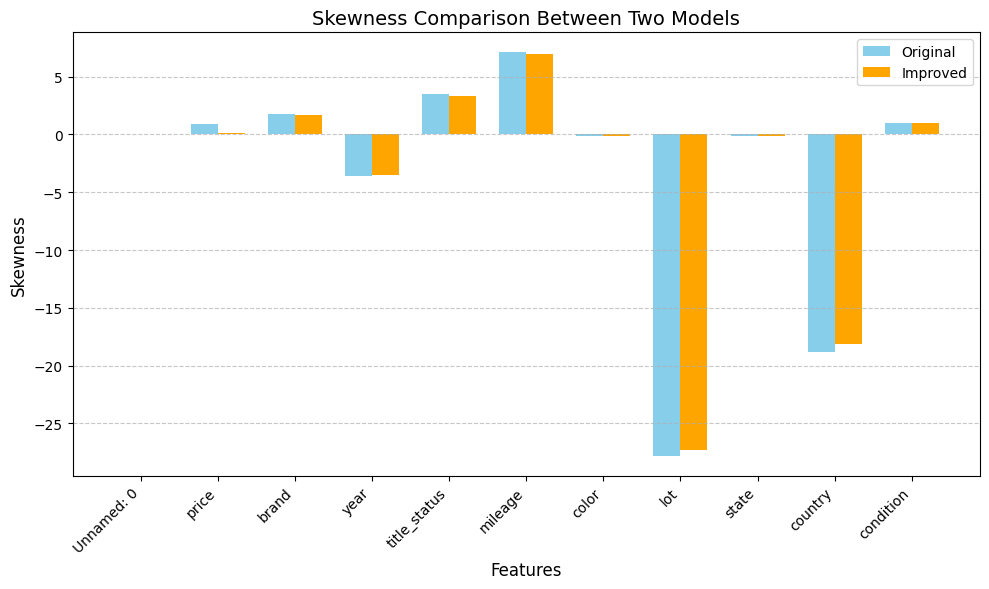

1. Outliers reduce
2. Log transformation
3. Normalize feature
4. Boolean features
5. Feature binning
6. Hyper parameters tuning
7. Days since today
8. Analyzing
Your choice: exit
Logs successfully exported to log_output


In [432]:

menu_list = [MenuItem('Outliers reduce', reduce_outliers),
             MenuItem('Log transformation', log_feature),
             MenuItem('Normalize feature', normalize_feature),
             MenuItem('Boolean features', add_boolean_features),
             MenuItem('Feature binning', bin_numerical_feature),
             MenuItem('Hyper parameters tuning', tune_hyperparameters),
             MenuItem('Days since today', add_days_since_today),
             MenuItem('Analyzing', analyze)]

reset_global_variables()

'''
in this function we will create a menu that will be displayed to the user and will ask the user to choose which feature engineerings method to use
'''
def run_menu():
  global dataset, target_feature, parent_folder, logger, original_dataset
  logger = Logger()
  dataset =  load_dataset()
  if dataset is None:
    return
  print('The dataset loaded successfully!')
  parent_folder = create_parent_folder()
  dataset, target_feature = pre_process_dataset(dataset)
  original_dataset = pd.DataFrame(dataset).copy()
  original_dataset = original_dataset.drop(columns=categorial_commass)
  _, _, _, _, _ = run_prediction(dataset, target_feature)
  print ('Please choose an option or type \'exit\' for exit.')
  while True:
    for i in range(len(menu_list)):
      print(f'{i + 1}. {menu_list[i]}')
    choice = input('Your choice: ')
    if choice == "exit":
      logger.export_logs()
      break
    try:
      int(choice)
    except ValueError:
      print('Invalid choice. Try again.')
      continue
    if int(choice) > len(menu_list) or int(choice) < 1:
      print('Invalid choice. Try again.')
      continue
    try:
      menu_list[int(choice) - 1].action(dataset)
    except Exception as e:
      logger.export_logs()
      raise Exception(e)

run_menu()